In [1]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.integrate import cumulative_trapezoid as cumtrapz
from scipy.interpolate import interp1d

import copernicusmarine

In [2]:
# calculate M_Lambd and F_Lambd

t = dynamicsymbols._t

x, y, z, theta, phi = dynamicsymbols("x y z theta phi")  # x and y -> buoy coordinates

m_b, m_d, l, g = sp.symbols(
    "m_b m_d l g", positive=True
)  # mass buoy, mass drogue in [kg], wire length in [m], g in [m(s^2)]

k_b, k_d = sp.symbols("k_b k_d", positive=True)  # drag coefficients for buoy and drogue

U_b, V_b, U_d, V_d = sp.symbols(
    "U_b V_b U_d V_d", real=True
)  # surface horizontal velocities

# U_0, V_0 = sp.symbols('U_0 V_0', real = True) # surface horizontal velocities

In [3]:
r_b = sp.Matrix([x, y, 0])  # buoy position

r = l * sp.Matrix(
    [
        sp.sin(theta) * sp.cos(phi),
        sp.sin(theta) * sp.sin(phi),
        sp.cos(theta),
    ]
)

r_d = r_b + r  # drogue position

display(r_d)

Matrix([
[l*sin(theta(t))*cos(phi(t)) + x(t)],
[l*sin(phi(t))*sin(theta(t)) + y(t)],
[                   l*cos(theta(t))]])

In [4]:
# velocities

v_b = r_b.diff(t)
v_d = r_d.diff(t)

u_b = sp.Matrix([U_b, V_b, 0])
u_d = sp.Matrix([U_d, V_d, 0])

In [5]:
def _mag(vec):
    return sp.sqrt(vec.dot(vec))


F_b = -k_b * _mag(v_b - u_b) * (v_b - u_b)  # drag buoy with ext. velocity
F_d = -k_d * _mag(v_d - u_d) * (v_d - u_d)  # drag drogue with ext. velocity

In [6]:
# lagrangian

T = sp.Rational(1, 2) * m_b * v_b.dot(v_b) + sp.Rational(1, 2) * m_d * v_d.dot(
    v_d
)  # kinetic energy

V = m_d * g * r_d[2]  # potential energy

L = T - V  # lagrangian

In [7]:
q = sp.Matrix([x, y, theta, phi])
qd = q.diff(t)
qdd = qd.diff(t)

In [8]:
Q = sp.Matrix([r_b.diff(qi).dot(F_b) + r_d.diff(qi).dot(F_d) for qi in q])

Q = sp.simplify(Q)

In [9]:
eoms = sp.Matrix(
    [L.diff(qdj).diff(t) - L.diff(qj) - Qj for qj, qdj, Qj in zip(q, qd, Q)]
)
eoms = sp.simplify(eoms)

In [10]:
M, F = sp.simplify(sp.linear_eq_to_matrix(eoms, list(qdd)))

In [54]:
M

Matrix([
[                                                 m_b + m_d,                                                          0, l*m_d*cos(phi(t))*cos(theta(t)), -l*m_d*sin(phi(t))*sin(theta(t))],
[                                                         0,                                                  m_b + m_d, l*m_d*sin(phi(t))*cos(theta(t)),  l*m_d*sin(theta(t))*cos(phi(t))],
[                           l*m_d*cos(phi(t))*cos(theta(t)),                            l*m_d*sin(phi(t))*cos(theta(t)),                        l**2*m_d,                                0],
[-l*m_d*(cos(phi(t) - theta(t)) - cos(phi(t) + theta(t)))/2, -l*m_d*(sin(phi(t) - theta(t)) - sin(phi(t) + theta(t)))/2,                               0, -l*m_d*(l*cos(2*theta(t)) - l)/2]])

In [11]:
par_syms = (m_b, m_d, l, g, k_b, k_d)
par_dict = {
    m_b: 0.5,
    m_d: 0.5,
    l: 3.0,
    g: 9.81,
    k_b: 0.5,
    k_d: 2.0,
}
par_vals = tuple(par_dict[k] for k in par_syms)

xd, yd, thetad, phid = qd

M_lambd = sp.lambdify(
    (t, x, y, theta, phi, xd, yd, thetad, phid, m_b, m_d, l, g, k_b, k_d, U_b, V_b, U_d, V_d), M,
    modules="numpy",)

F_lambd = sp.lambdify(
    (t, x, y, theta, phi, xd, yd, thetad, phid, m_b, m_d, l, g, k_b, k_d, U_b, V_b, U_d, V_d), F,
    modules="numpy",)

def get_uv(
    t, z_d, y, x, ds
):  # sadly I couldn't figure ot how to do this without loading the dataset four times.
    """Get horizontal currents at and drogue and buoy level."""

    time = time0 + t * np.timedelta64(1000, "ms")

    lon, lat = convert_to_lonlat(y_in_m=y, x_in_m=x)
    # not shown: conversion of (x,y) --> (lon,lat)

    # TODO: Note that this will load separately four times.
    # better: get ds_water_colum_at_time = ds.sel(time=..., latitude=..., longitude=...).load()
    # and then select U_b etc from there justing with depth=...

    U_b = (
        ds.sel(
            time=time,
            depth=0,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .uo.load()
        .data[()]
    )
    # load actually gets the data, .data[()] converts singleton xarray object to single number

    U_d = (
        ds.sel(
            time=time,
            depth=-z_d,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .uo.load()
        .data[()]
    )

    V_b = (
        ds.sel(
            time=time,
            depth=0,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .vo.load()
        .data[()]
    )

    V_d = (
        ds.sel(
            time=time,
            depth=-z_d,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .vo.load()
        .data[()]
    )

    return U_b, V_b, U_d, V_d

In [108]:
def get_uv(t, z_d, y, x, ds):
    U_b, V_b = 1.0, 0.2
    factor = np.exp(-abs(z_d) / 3.0)
    U_d, V_d = U_b * factor, V_b * factor
    return U_b, V_b, U_d, V_d

In [124]:
def calc_netto_drift(
    par_vals,
    t_span,
    t_eval, # check exact meaning
    y0,
    ds_subset,
    U_z: xr.DataArray = None, # xy-local and instantaneous vertical profile
    M_lambd: callable = None,
    F_lambd: callable = None,
    # initial guesses for phi, theta, xdot, ydot
):
    def rhs(t_num, y, par_vals):
        
        q_num = y[:4]
        qd_num = y[4:]

        x_b, y_b, th, ph = q_num

        length = par_vals[2]
        
        z_d = float(max(0.0, length * np.cos(th)))

        U_b, V_b, U_d, V_d = get_uv(t_num, z_d, y_b, x_b, ds_subset) 
        
        dyn_params = (*par_vals, U_b, V_b, U_d, V_d)

        M_num = np.array(M_lambd(t_num, *q_num, *qd_num, *dyn_params), dtype=float) # als dict
        F_num = np.array(F_lambd(t_num, *q_num, *qd_num, *dyn_params), dtype=float).reshape(-1)
        try:
            qdd_num = np.linalg.solve(M_num, F_num)
        except Exception as e:
            # raise e
            qdd_num = np.zeros(shape = (4,))
            qdd_num[:3] = np.linalg.solve(M_num[:3,:3], F_num[:3])
            qdd_num[3] = .1

        return np.concatenate([qd_num, qdd_num])

    sol = solve_ivp(rhs, t_span, y0, args = (par_vals, ), atol=1e-3, rtol=1e-3)

    dt = sol.t[-1] - sol.t[0]
    Eq_U_Drift = sol.y[4, -1]
    Eq_V_Drift = sol.y[5, -1]

    y_next = sol.y[:, -1]
    
    return (Eq_U_Drift, Eq_V_Drift, y_next, sol)

In [125]:
y0 = np.array([0.0, 0.0, np.pi, np.pi - 0.2,   0.0, 0.0, 0.0, 0.0])

t_span = (0.0, 600.0)
t_eval = np.linspace(t_span[0], t_span[1], 101) 


In [126]:
%pdb off

Automatic pdb calling has been turned OFF


In [127]:
U_Drift, V_Drift, y_next, sol = calc_netto_drift(
    par_vals = par_vals,
    t_span = t_span,
    t_eval = t_eval,
    y0 = y0,
    ds_subset = None,
    M_lambd = M_lambd,
    F_lambd = F_lambd,
)

print(U_Drift, V_Drift, y_next)

0.059835118716418556 990.2042792995036 [ 2.63976410e-15  6.77504856e-16  3.14159265e+00  2.26056774e+01
  5.98351187e-02  9.90204279e+02 -2.84955892e+02  3.32385703e+18]


/var/folders/kv/m9728dx96_dfgqw5xnsv8njm0000gn/T/ipykernel_2376/3011290801.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(sol.y[4, :]))
/var/folders/kv/m9728dx96_dfgqw5xnsv8njm0000gn/T/ipykernel_2376/3011290801.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(sol.y[4, :]))


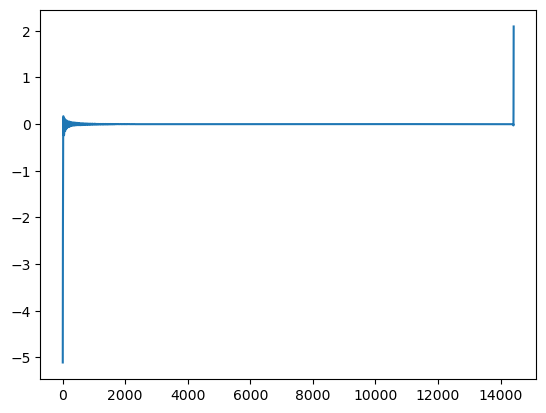

In [120]:
plt.plot(np.log(sol.y[4, :]))

In [52]:
sol

  message: Required step size is less than spacing between numbers.
  success: False
   status: -1
        t: [ 0.000e+00  9.548e-02 ...  8.884e+01  8.884e+01]
        y: [[ 0.000e+00 -3.455e-03 ...  8.819e+01  8.819e+01]
            [ 0.000e+00 -7.129e-04 ...  1.820e+01  1.820e+01]
            ...
            [ 0.000e+00  9.588e-02 ... -1.690e-01 -3.731e-01]
            [ 0.000e+00  2.505e-04 ... -1.315e+12 -2.256e+12]]
      sol: None
 t_events: None
 y_events: None
     nfev: 16202
     njev: 0
      nlu: 0